<a href="https://colab.research.google.com/github/ThierrySHYAKA/linear_regression_model/blob/main/Thierry_SHYAKA_Summative_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Necessary Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pickle
import joblib

Load Dataset

In [14]:
from google.colab import files
uploaded = files.upload()

Saving salary_prediction_data.csv to salary_prediction_data (1).csv


In [15]:
df = pd.read_csv('salary_prediction_data.csv')
df.columns = df.columns.str.strip()

Exploratory Data Analysis

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-1' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:69> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/main.py", line 580, in run
    server.run()
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 67, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
    se

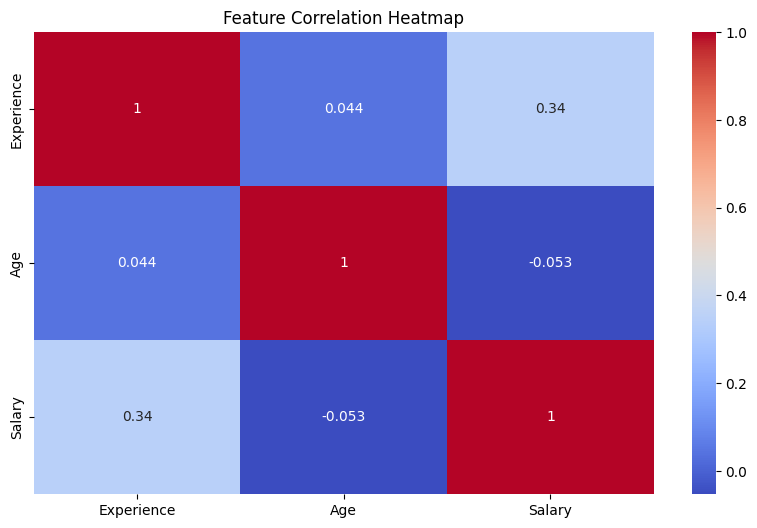

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

Data Preprocessing

In [17]:
df = df.dropna()

# Select feature and target columns
X = df[['Experience']]
y = df['Salary']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Linear Regression using Gradient Descent

In [18]:
sgd = SGDRegressor(max_iter=1, eta0=0.01, learning_rate='constant', tol=None, random_state=42)
train_losses = []
test_losses = []

for i in range(100):
    sgd.partial_fit(X_train, y_train)
    train_pred = sgd.predict(X_train)
    test_pred = sgd.predict(X_test)
    train_losses.append(mean_squared_error(y_train, train_pred))
    test_losses.append(mean_squared_error(y_test, test_pred))

Plot Loss Curve

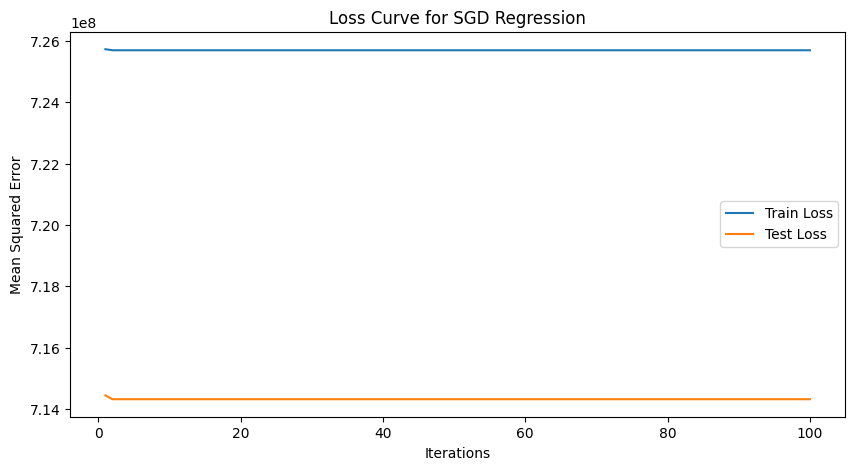

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 101), train_losses, label='Train Loss')
plt.plot(range(1, 101), test_losses, label='Test Loss')
plt.xlabel("Iterations")
plt.ylabel("Mean Squared Error")
plt.title("Loss Curve for SGD Regression")
plt.legend()
plt.show()

Compare Models

In [20]:
models = {
    'Linear Regression (GD)': sgd,
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

errors = {}
for name, model in models.items():
    if name != 'Linear Regression (GD)':
        model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    errors[name] = mse
    print(f"{name} MSE: {mse:.2f}")

Linear Regression (GD) MSE: 714326135.58
Random Forest MSE: 673660335.75
Decision Tree MSE: 674566598.67


Save Best Model

In [21]:
best_model_name = min(errors, key=errors.get)
best_model = models[best_model_name]
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save scaler for preprocessing
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Visualize Regression Line

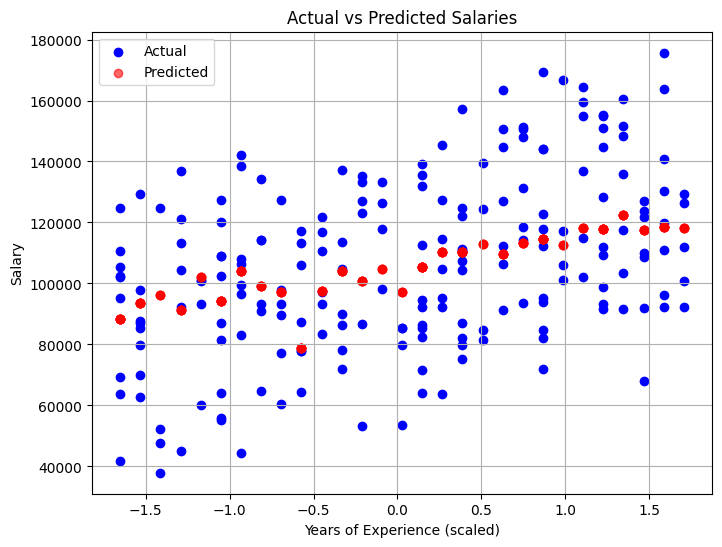

In [22]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', alpha=0.6, label='Predicted')
plt.title("Actual vs Predicted Salaries")
plt.xlabel("Years of Experience (scaled)")
plt.ylabel("Salary")
plt.legend()
plt.grid(True)
plt.show()

Saved Model

In [23]:
from sklearn.linear_model import LinearRegression
import joblib

model = LinearRegression()
model.fit(X_train, y_train)

import os
os.makedirs("model", exist_ok=True)
joblib.dump(model, "model/model.pkl")

['model/model.pkl']

API Code for Prediction

In [24]:
from fastapi import FastAPI
from pydantic import BaseModel, Field
from fastapi.middleware.cors import CORSMiddleware
import uvicorn
import nest_asyncio
import os

app = FastAPI()

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

class InputData(BaseModel):
    years_experience: float = Field(..., ge=0.0, le=50.0, description="Years of experience between 0 and 50")

@app.post("/predict")
def predict(data: InputData):
    if not os.path.exists("best_model.pkl") or not os.path.exists("scaler.pkl"):
        return {"error": "Model or scaler file not found."}

    model = joblib.load("best_model.pkl")
    scaler = joblib.load("scaler.pkl")
    input_scaled = scaler.transform([[data.years_experience]])
    prediction = model.predict(input_scaled)[0]
    return {"predicted_salary": prediction}

if __name__ == "__main__":
    nest_asyncio.apply()
    uvicorn.run(app, host="0.0.0.0", port=8000)

INFO:     Started server process [240]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [240]
